### Otimização de dados através de hiperparametros

"stratified" = Properção

In [2]:
!pip install graphviz
!pip install pydot

In [3]:
import pandas as pd

uri = 'https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv'
data = pd.read_csv(uri)

new_columns_name = {
    'preco' : 'price',
    'idade_do_modelo' : 'model_age',
    'km_por_ano' : 'km_per_year',
    'vendido' : 'sold'
}

data = data.drop(columns=['Unnamed: 0'], axis=1)
data = data.rename(columns=new_columns_name)

data.head()

,price,sold,model_age,km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


#### Situação de azar

In [4]:
unlucky_data = data.sort_values('sold', ascending=True)

unlucky_x = unlucky_data[['price', 'model_age', 'km_per_year']]
unlucky_y = unlucky_data['sold']

unlucky_data.head()

,price,sold,model_age,km_per_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


#### Função para printar o resultado

In [5]:
def print_results(results):
    average = results['test_score'].mean() * 100
    average_default_detour = results['test_score'].std() * 100

    print('- Precisão da média: %.2f' % average)
    print('- Precisão do desvio padrão da média: [%.2f, %.2f]' % (average - 2 * average_default_detour, average + 2 * average_default_detour))

#### Base line com dummy classifier

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

import numpy as np

SEED = 301
np.random.seed(SEED)

model = DummyClassifier()
results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=False)

print_results(results)

- Precisão da média: 58.00
- Precisão do desvio padrão da média: [58.00, 58.00]


#### Base line com o decision tree classifier

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

import numpy as np

SEED = 301
np.random.seed(SEED)

model = DecisionTreeClassifier()
results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=False)

print_results(results)

- Precisão da média: 72.19
- Precisão do desvio padrão da média: [68.67, 75.71]


#### Cria a coluna "modelo" aleatóriamente

In [8]:
np.random.seed(SEED)

data['model'] = data['model_age'] + np.random.randint(-2, 3, size=10000)
data['model'] = data['model'] + abs(data['model'].min()) + 1

data.head()

,price,sold,model_age,km_per_year,model
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


#### Validação cruzada com SVC

In [9]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GroupKFold
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC

# SEED = 301
# np.random.seed(SEED)

# scaler = StandardScaler()
# model = SVC()

# pipeline = Pipeline([ ('transformation', scaler), ('estimator', model) ])
# cross_validation_group = GroupKFold(n_splits=10)

# results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=False)
# print_results(results)

#### Validação cruzada que agrupa pelo model do carro

In [10]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cross_validation_group = GroupKFold(n_splits=10)

model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=False)

print_results(results)

- Precisão da média: 75.78
- Precisão do desvio padrão da média: [73.83, 77.73]


#### Renderiza a arvore de classificação

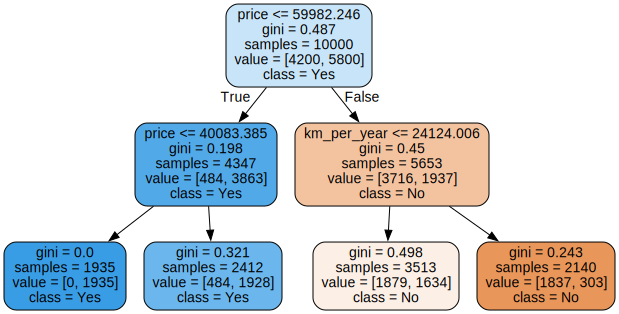

In [11]:
from sklearn.tree import export_graphviz
import graphviz

model.fit(unlucky_x, unlucky_y)

features = unlucky_x.columns
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=features)

graph = graphviz.Source(dot_data)
graph

#### Overfit

Ficou "perfeito" para o treino mas ruim para o teste = RUIM

In [12]:
def run_decision_tree(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cross_validation_group = GroupKFold(n_splits=10)

    model = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=True)

    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100

    return [ max_depth, train_score, test_score ]

# List comprerencion
# Para cada um desses "index" rode a função "run_decision_tree" e retorna uma lista de resultados
results = [run_decision_tree(index) for index in range(1, 33)]
results = pd.DataFrame(results, columns=['max_depth', 'train_score', 'test_score'])

results.head()

,max_depth,train_score,test_score
0,1,75.791111,75.78
1,2,75.791111,75.78
2,3,78.754444,78.70
3,4,78.800000,78.63
4,5,78.965556,78.56


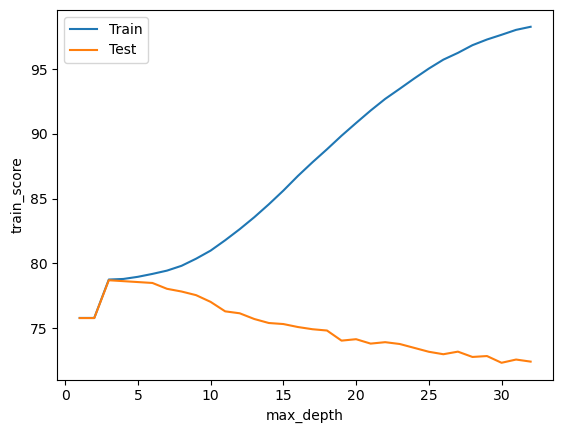

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x='max_depth', y='train_score', data=results)
sns.lineplot(x='max_depth', y='test_score', data=results)

plt.legend(['Train', 'Test'])

#### Arvore de decisão com hiper parametros em 2 dimensões

In [14]:
def run_decision_tree(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cross_validation_group = GroupKFold(n_splits=10)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=True)

    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100

    return [ max_depth, min_samples_leaf, train_score, test_score ]

results = []

for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 252]:
        table = run_decision_tree(max_depth, min_samples_leaf)
        results.append(table)

results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
results.head()

,max_depth,min_samples_leaf,train_score,test_score
0,1,32,75.791111,75.78
1,1,64,75.791111,75.78
2,1,128,75.791111,75.78
3,1,252,75.791111,75.78
4,2,32,75.791111,75.78


#### Arvore de decisão com hiper parametros em 3 dimensões

In [17]:
def run_decision_tree(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cross_validation_group = GroupKFold(n_splits=10)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(model, unlucky_x, unlucky_y, cv=10, return_train_score=True)

    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100

    return [ max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time ]

results = []

for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 252]:
        for min_samples_split in [32, 64, 128, 252]:
            table = run_decision_tree(max_depth, min_samples_leaf, min_samples_split)
            results.append(table)

results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train_score', 'test_score', 'fit_time', 'score_time'])
results.head()

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
0,1,32,32,75.791111,75.78,0.004400,0.001300
1,1,32,64,75.791111,75.78,0.003699,0.000801
2,1,32,128,75.791111,75.78,0.003397,0.000702
3,1,32,252,75.791111,75.78,0.003397,0.000702
4,1,64,32,75.791111,75.78,0.003397,0.000802


In [23]:
results.sort_values('test_score', ascending=True).head()

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score,fit_time,score_time
0,1,32,32,75.791111,75.78,0.004400,0.001300
31,2,252,252,75.791111,75.78,0.005399,0.000901
30,2,252,128,75.791111,75.78,0.005498,0.000901
29,2,252,64,75.791111,75.78,0.005300,0.000800
28,2,252,32,75.791111,75.78,0.005300,0.000800


#### Explorando espaço entre hiper parametros com GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.tree import DecisionTreeClassifier

import numpy as np

SEED = 301
np.random.seed(SEED)

params_space = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

model = DecisionTreeClassifier()
cross_validation_group = GroupKFold(n_splits=10)

search = GridSearchCV(model, params_space, cv=cross_validation_group)
search.fit(unlucky_x, unlucky_y, groups=data['model'])

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007600,0.000916,0.001199,0.000399,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007400,0.000917,0.001000,0.000446,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.007100,0.000300,0.001000,0.000001,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007100,0.000538,0.000800,0.000400,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.006699,0.000458,0.000800,0.000400,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [27]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

#### Abordagem muito otimista , NÃO deve ser usada

In [28]:
from sklearn.metrics import accuracy_score

best_estimator = search.best_estimator_
predictions = best_estimator.predict(unlucky_x)

accuracy = accuracy_score(predictions, unlucky_y) * 100
print('Taxa de acerto para os dados do melhor estimador: %.2f%%' % accuracy)

Taxa de acerto para os dados do melhor estimador: 78.75%


### Abordagem correta
No caso de cross validation com busca de hiper parametros, fazemos uma nova validação cruzada. Chama-se nested cross validation.
Está é a maneira correta para a validação do melhores resultado.

Infelizmente o pandas não suporta nested validation com GroupKFold, por isso não conseguimos prever o resultado para novos grupos.

In [29]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier

import numpy as np

SEED = 301
np.random.seed(SEED)

params_space = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

model = DecisionTreeClassifier()
cross_validation = KFold(n_splits=5, shuffle=True)

search = GridSearchCV(model, params_space, cv=cross_validation)
search.fit(unlucky_x, unlucky_y)

results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007091,0.000730,0.001603,0.000539,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006648,0.000492,0.001131,0.000226,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.006400,0.000799,0.000800,0.000400,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006200,0.000402,0.001001,0.000001,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.006200,0.000401,0.000800,0.000400,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [30]:
from sklearn.model_selection import cross_val_score

cross_validation = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(search, unlucky_x, unlucky_y, cv=cross_validation)

print_results({ 'test_score': scores, 'test_score': scores })

- Precisão da média: 78.67
- Precisão do desvio padrão da média: [76.80, 80.54]


In [33]:
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

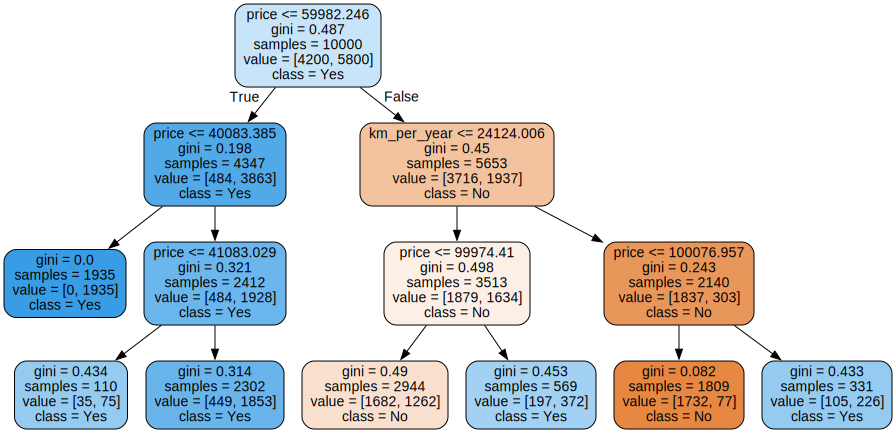

In [34]:
from sklearn.tree import export_graphviz
import graphviz

features = unlucky_x.columns
dot_data = export_graphviz(best_estimator, out_file=None, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=features)

graph = graphviz.Source(dot_data)
graph